In [1]:
#!pip install transformers torch
#!pip install GPUtil
# !python -m spacy download fr_core_news_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
print(torch.__version__)
print(torch.version.cuda)

# Core packages for text processing.

import string
import re

# Base path for Kaggle input directory
base_path = '/kaggle/input/projet-ter/'  # Update this path if it's different

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    # Vérifier si CUDA est disponible
    if not torch.cuda.is_available():
        print("CUDA n'est pas disponible. Aucun GPU trouvé !")
        return

    print("Utilisation initiale du GPU")
    gpu_usage()

    # Essayer de vider le cache du GPU
    try:
        torch.cuda.empty_cache()
    except RuntimeError as e:
        print("Erreur lors du vidage du cache CUDA :", e)

    # Réinitialiser le contexte CUDA
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("Utilisation du GPU après avoir vidé le cache")
    gpu_usage()

free_gpu_cache()



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.0.0
11.8
Utilisation initiale du GPU
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
Utilisation du GPU après avoir vidé le cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  2% |


# Import df sentiment des pertinents

In [2]:
import pandas as pd

file_path = '/kaggle/input/df-sentiments/df_sentiments.csv'  

df_sentiment = pd.read_csv(file_path)

# Afficher les 5 premières lignes pour vérifier
df_sentiment

,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No,predicted_label_MLM,confidence_mlm,Polarity,Subjectivity,Sentiment_blob,Sentiment_classe,Confidence,sentiment_bert
0,NaN,RJ5H4F3A8T,""" "" : quand les tensions entre le Maroc et l’...",0,0.606776,No (m),1,0.729357,0.057097,0.214516,Négatif,0,0.305406,Négatif
1,NaN,MAOS6IZWSH,Bradage des terres de l’aéroport léopold sédar...,0,0.816456,Yes (m),1,0.812326,0.064000,0.143333,Négatif,0,0.362451,Négatif
2,NaN,OQ8FYHDR2Q,COP21 : la Tunisie et 6 autres nouveaux pays a...,0,0.757143,No (m),1,0.684343,0.095405,0.178378,Négatif,2,0.284874,Neutre
3,NaN,CHIOM99SJZ,Saint-Louis- élection présidentielle de 2024 :...,1,0.637125,Yes (m),1,0.915263,0.084231,0.188462,Négatif,3,0.409618,Positif
4,NaN,NHHFVWZDHE,Location de terres agricoles en milieu rural a...,1,0.605540,No (m),1,0.898125,0.039561,0.170877,Négatif,3,0.273582,Positif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,NaN,TUDIKWP2XH,"L’Afrique face à l’Ukraine : s’engager, oui, s...",0,0.764944,No (m),1,0.734130,0.031785,0.157206,Négatif,1,0.249161,Négatif
995,NaN,QER9ZQEBV5,Les députés en séance plénière pour l’examen d...,1,0.577608,Yes (m),1,0.908876,0.081538,0.188462,Négatif,0,0.278799,Négatif
996,NaN,25U6N7JIBP,Forum sur l’investissement à Ryad: l’appel de ...,0,0.517440,No (m),1,0.871158,0.110000,0.200000,Négatif,3,0.450137,Positif
997,NaN,6HO4NJIYBE,Communiqué de presse du MFDC\n\nMouvement pour...,0,0.847978,No (m),1,0.706712,0.040395,0.238514,Négatif,0,0.617065,Négatif


In [3]:
columns_list = df_sentiment.columns
columns_list

Index(['label', 'id', 'text', 'predicted_label', 'confidence',
       'CLS_Relevance Yes/No', 'predicted_label_MLM', 'confidence_mlm',
       'Polarity', 'Subjectivity', 'Sentiment_blob', 'Sentiment_classe',
       'Confidence', 'sentiment_bert'],
      dtype='object')

In [4]:
print(df_sentiment['id'].is_unique)

True


# Import de tout les articles

In [5]:
file_names = [
    "articles_24 Heures au BCnin.www.24haubenin.info_.csv",
    "articles_Africa 24.www.youtube.com_channel_UCmEcEP_oCZJ6Mr1uxhUFyRg.csv",
    "articles_Agence de Presse Sngalaise Youtube.www.youtube.com_channel_UC8uoOv4RSzdZKlmPTguYjtg.csv",
    "articles_Agence de Presse Sngalaise.www.aps.sn_.csv",
    "articles_Banouto Media.www.youtube.com_channel_UCwsXkG4LatsF7u_b8dU1p-w.csv",
    "articles_Banouto.www.banouto.bj_.csv",
    "articles_Burkina24 Youtube.www.youtube.com_channel_UCJtaDORHQO20XA-tFwpJysQ.csv",
    "articles_Burkina24.burkina24.com_.csv",
    "articles_Dakaractu TV HD.www.youtube.com_channel_UCG0t6XiAHui-ziz7SwFTN0g.csv",
    "articles_Dakaractu.www.dakaractu.com_.csv",
    "articles_Fraternit.www.fraternitebj.info_.csv",
    "articles_JeuneAfrique Youtube.www.youtube.com_channel_UCWkbzzrku8lwKK6DoBl4yTg.csv",
    "articles_JeuneAfrique.www.jeuneafrique.com_.csv",
    "articles_LObs.www.lobs.sn_.csv",
    "articles_La Nation.lanation.bj_.csv",
    "articles_La Nouvelle Tribune.lanouvelletribune.info_.csv",
    "articles_Le Matinal.groupelematinal.com_category_actualites_.csv",
    "articles_Le Quotidien.lequotidien.sn_.csv",
    "articles_ORTB.www.youtube.com_channel_UCmPXzeJaO7nrA87GIz3N6wQ.csv",
    "articles_RTB - Radiodiffusion Tlvision du Burkina.www.youtube.com_channel_UCZl9utbYlPMssMhgrGUqXZA.csv",
    "articles_SIKKA TELEVISION.www.youtube.com_channel_UCplwKOWLV8s2XZBMsimOjvg.csv",
    "articles_Senegal7.www.youtube.com_channel_UC5eVGjO4ITJA1KM_tva_OSQ.csv",
    "articles_Sud Quotidien TV.www.youtube.com_channel_UCD-YykHgK3BOvnqFlcOFXIA.csv",
    "articles_Sud Quotidien.www.sudquotidien.sn_.csv",
    "articles_TFM (Tl Futurs Medias).www.youtube.com_channel_UC5NQ49FVRIAuWE1el6L2gkg.csv",
    "articles_aCotonou Youtube.www.youtube.com_channel_UCdNz-U4WJwFvbMDMdgYNMrg.csv",
    "articles_aCotonou.news.acotonou.com_.csv",
    "articles_le faso.lefaso.net_.csv",
    "articles_le soleil.lesoleil.sn_.csv",
]

# Initialize an empty list to store dataframes
dfs = []

# Loop through the file names
for file_name in file_names:
    file_path = f"{base_path}{file_name}"
    
    # Read each file into a dataframe
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_path)
        
        # Check if 'source' column exists and does not contain YouTube links
        if 'source' in df.columns and not df['source'].str.contains('youtube.com').any():
            dfs.append(df)

# Concatenate all the dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Verify the combined dataframe
print(f"\nTotal number of records in the combined dataframe: {len(combined_df)}")


Total number of records in the combined dataframe: 23894


In [6]:
columns_list = combined_df.columns
columns_list

Index(['id', 'title', 'text', 'url', 'lang', 'source_lang', 'created_at',
       'published_at', 'rssfeed_id', 'source', 'country', 'continent',
       'reference_id', 'reference_key', 'keyword_list', 'location_list',
       'publication_date', 'CLS_Lexique Sécurité Alimentaire', 'CLS_Relevance',
       'CLS_Usefulness', 'CLS_Relevance Yes/No', 'CLS_Topic'],
      dtype='object')

In [7]:
print(combined_df['id'].is_unique)

True


# Cluster sentiment

In [8]:
df_cluster = df_sentiment.drop(columns=['label', 'id', 'text', 'predicted_label',
       'CLS_Relevance Yes/No', 'predicted_label_MLM', 'sentiment_bert', 'confidence'])
columns_list = df_cluster.columns
columns_list


Index(['confidence_mlm', 'Polarity', 'Subjectivity', 'Sentiment_blob',
       'Sentiment_classe', 'Confidence'],
      dtype='object')

In [9]:
df_cluster

,confidence_mlm,Polarity,Subjectivity,Sentiment_blob,Sentiment_classe,Confidence
0,0.729357,0.057097,0.214516,Négatif,0,0.305406
1,0.812326,0.064000,0.143333,Négatif,0,0.362451
2,0.684343,0.095405,0.178378,Négatif,2,0.284874
3,0.915263,0.084231,0.188462,Négatif,3,0.409618
4,0.898125,0.039561,0.170877,Négatif,3,0.273582
...,...,...,...,...,...,...
994,0.734130,0.031785,0.157206,Négatif,1,0.249161
995,0.908876,0.081538,0.188462,Négatif,0,0.278799
996,0.871158,0.110000,0.200000,Négatif,3,0.450137
997,0.706712,0.040395,0.238514,Négatif,0,0.617065


In [10]:
replace_dict = {'Positif': 1, 'Négatif': -1, 'Neutre': 0}

df_cluster['Sentiment_blob'] = df_cluster['Sentiment_blob'].replace(replace_dict)

print(df_cluster[['Sentiment_blob']].head())


   Sentiment_blob
0              -1
1              -1
2              -1
3              -1
4              -1


In [11]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   confidence_mlm    999 non-null    float64
 1   Polarity          999 non-null    float64
 2   Subjectivity      999 non-null    float64
 3   Sentiment_blob    999 non-null    int64  
 4   Sentiment_classe  999 non-null    int64  
 5   Confidence        999 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 47.0 KB


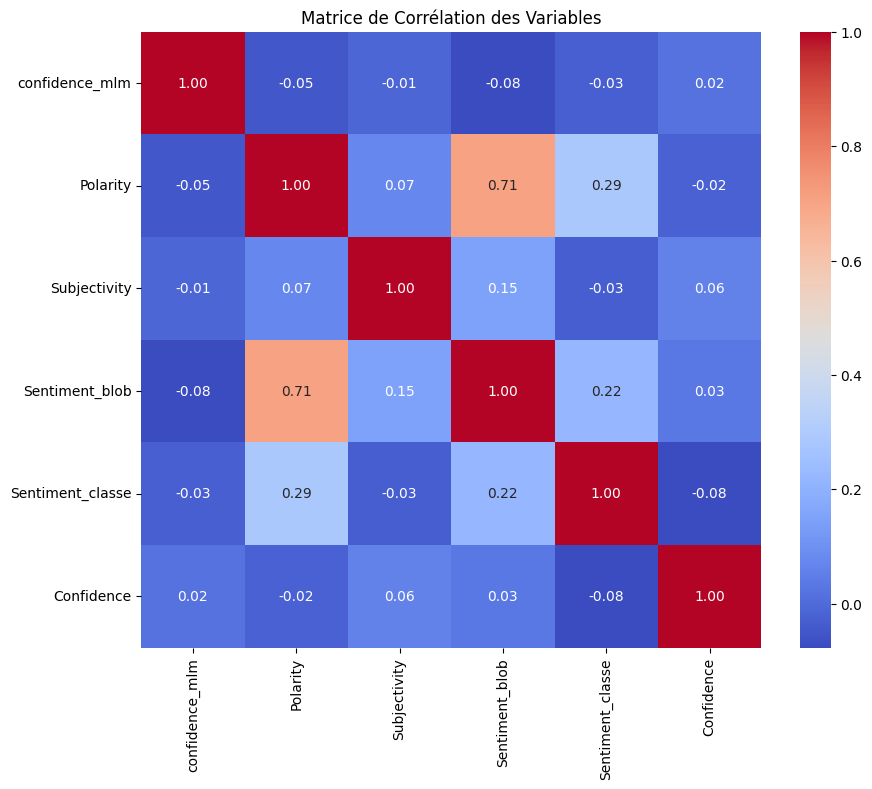

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_cluster.corr()

# Configurer la visualisation
plt.figure(figsize=(10, 8))

# Créer une heatmap pour la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Titre du graphique
plt.title('Matrice de Corrélation des Variables')

# Montrer le graphique
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

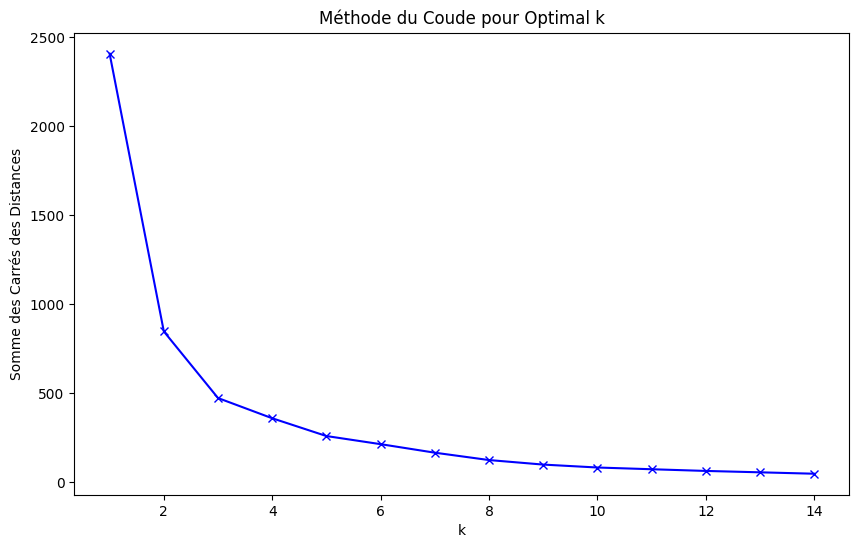

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Tester K-means avec différents nombres de clusters
sum_of_squared_distances = []
K = range(1, 15)  # Par exemple, tester de 1 à 14 clusters
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_cluster)
    sum_of_squared_distances.append(km.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Somme des Carrés des Distances')
plt.title('Méthode du Coude pour Optimal k')
plt.show()

In [14]:
# Remplacer 'k_optimal' par le nombre de clusters choisi
k_optimal = 3

# Création du modèle K-means
kmeans = KMeans(n_clusters=k_optimal)
kmeans = kmeans.fit(df_cluster)

# Ajout des étiquettes de cluster au DataFrame
df_cluster['cluster_sentiment'] = kmeans.labels_


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


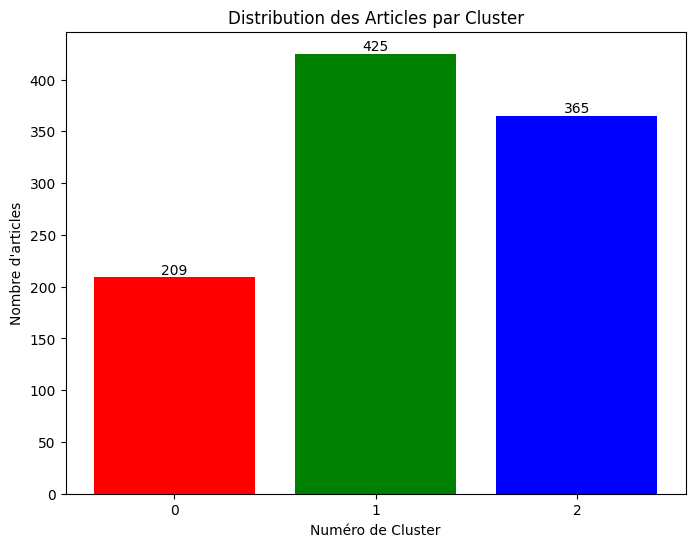

In [15]:
import matplotlib.pyplot as plt

# Configuration initiale
k_optimal = 3  # Le nombre optimal de clusters
cluster_counts = df_cluster['cluster_sentiment'].value_counts().sort_index()

# Assurez-vous que tous les clusters de 0 à k_optimal-1 sont représentés, même s'ils n'ont pas d'articles
cluster_counts = cluster_counts.reindex(range(k_optimal), fill_value=0)

# Configurer les paramètres du graphique
plt.figure(figsize=(8, 6))  # Taille de la figure
bars = plt.bar(range(k_optimal), cluster_counts, color=['red', 'green', 'blue'])  # Créer un histogramme

# Ajouter des titres et des étiquettes
plt.title('Distribution des Articles par Cluster')  # Ajouter un titre au graphique
plt.xlabel('Numéro de Cluster')  # Étiquette de l'axe x
plt.ylabel('Nombre d\'articles')  # Étiquette de l'axe y
plt.xticks(range(k_optimal))  # S'assurer que tous les clusters sont marqués

# Ajouter des étiquettes de nombre d'articles au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()  # Obtient la hauteur de la barre
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Montrer le graphique
plt.show()


In [16]:
df_sentiment = pd.concat([df_sentiment, df_cluster['cluster_sentiment']], axis=1)
df_sentiment

,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No,predicted_label_MLM,confidence_mlm,Polarity,Subjectivity,Sentiment_blob,Sentiment_classe,Confidence,sentiment_bert,cluster_sentiment
0,NaN,RJ5H4F3A8T,""" "" : quand les tensions entre le Maroc et l’...",0,0.606776,No (m),1,0.729357,0.057097,0.214516,Négatif,0,0.305406,Négatif,2
1,NaN,MAOS6IZWSH,Bradage des terres de l’aéroport léopold sédar...,0,0.816456,Yes (m),1,0.812326,0.064000,0.143333,Négatif,0,0.362451,Négatif,2
2,NaN,OQ8FYHDR2Q,COP21 : la Tunisie et 6 autres nouveaux pays a...,0,0.757143,No (m),1,0.684343,0.095405,0.178378,Négatif,2,0.284874,Neutre,1
3,NaN,CHIOM99SJZ,Saint-Louis- élection présidentielle de 2024 :...,1,0.637125,Yes (m),1,0.915263,0.084231,0.188462,Négatif,3,0.409618,Positif,1
4,NaN,NHHFVWZDHE,Location de terres agricoles en milieu rural a...,1,0.605540,No (m),1,0.898125,0.039561,0.170877,Négatif,3,0.273582,Positif,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,NaN,TUDIKWP2XH,"L’Afrique face à l’Ukraine : s’engager, oui, s...",0,0.764944,No (m),1,0.734130,0.031785,0.157206,Négatif,1,0.249161,Négatif,2
995,NaN,QER9ZQEBV5,Les députés en séance plénière pour l’examen d...,1,0.577608,Yes (m),1,0.908876,0.081538,0.188462,Négatif,0,0.278799,Négatif,2
996,NaN,25U6N7JIBP,Forum sur l’investissement à Ryad: l’appel de ...,0,0.517440,No (m),1,0.871158,0.110000,0.200000,Négatif,3,0.450137,Positif,1
997,NaN,6HO4NJIYBE,Communiqué de presse du MFDC\n\nMouvement pour...,0,0.847978,No (m),1,0.706712,0.040395,0.238514,Négatif,0,0.617065,Négatif,2


# Cluster texte

In [17]:
df_sentiment

,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No,predicted_label_MLM,confidence_mlm,Polarity,Subjectivity,Sentiment_blob,Sentiment_classe,Confidence,sentiment_bert,cluster_sentiment
0,NaN,RJ5H4F3A8T,""" "" : quand les tensions entre le Maroc et l’...",0,0.606776,No (m),1,0.729357,0.057097,0.214516,Négatif,0,0.305406,Négatif,2
1,NaN,MAOS6IZWSH,Bradage des terres de l’aéroport léopold sédar...,0,0.816456,Yes (m),1,0.812326,0.064000,0.143333,Négatif,0,0.362451,Négatif,2
2,NaN,OQ8FYHDR2Q,COP21 : la Tunisie et 6 autres nouveaux pays a...,0,0.757143,No (m),1,0.684343,0.095405,0.178378,Négatif,2,0.284874,Neutre,1
3,NaN,CHIOM99SJZ,Saint-Louis- élection présidentielle de 2024 :...,1,0.637125,Yes (m),1,0.915263,0.084231,0.188462,Négatif,3,0.409618,Positif,1
4,NaN,NHHFVWZDHE,Location de terres agricoles en milieu rural a...,1,0.605540,No (m),1,0.898125,0.039561,0.170877,Négatif,3,0.273582,Positif,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,NaN,TUDIKWP2XH,"L’Afrique face à l’Ukraine : s’engager, oui, s...",0,0.764944,No (m),1,0.734130,0.031785,0.157206,Négatif,1,0.249161,Négatif,2
995,NaN,QER9ZQEBV5,Les députés en séance plénière pour l’examen d...,1,0.577608,Yes (m),1,0.908876,0.081538,0.188462,Négatif,0,0.278799,Négatif,2
996,NaN,25U6N7JIBP,Forum sur l’investissement à Ryad: l’appel de ...,0,0.517440,No (m),1,0.871158,0.110000,0.200000,Négatif,3,0.450137,Positif,1
997,NaN,6HO4NJIYBE,Communiqué de presse du MFDC\n\nMouvement pour...,0,0.847978,No (m),1,0.706712,0.040395,0.238514,Négatif,0,0.617065,Négatif,2


# Nettoyage des Données

In [18]:
import re

def clean_text(text):
    # Supprimer les caractères spéciaux et les chiffres
    text = re.sub(r'[^a-zA-Zéèàêâôûùïüë]', ' ', text)
    # Remplacer les multiples espaces par un seul
    text = re.sub(r'\s+', ' ', text)
    return text

# Appliquer la fonction de nettoyage
df_sentiment['cleaned_text'] = df_sentiment['text'].apply(clean_text)

df_sentiment.head()

,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No,predicted_label_MLM,confidence_mlm,Polarity,Subjectivity,Sentiment_blob,Sentiment_classe,Confidence,sentiment_bert,cluster_sentiment,cleaned_text
0,NaN,RJ5H4F3A8T,""" "" : quand les tensions entre le Maroc et l’...",0,0.606776,No (m),1,0.729357,0.057097,0.214516,Négatif,0,0.305406,Négatif,2,quand les tensions entre le Maroc et l Algéri...
1,NaN,MAOS6IZWSH,Bradage des terres de l’aéroport léopold sédar...,0,0.816456,Yes (m),1,0.812326,0.064000,0.143333,Négatif,0,0.362451,Négatif,2,Bradage des terres de l aéroport léopold sédar...
2,NaN,OQ8FYHDR2Q,COP21 : la Tunisie et 6 autres nouveaux pays a...,0,0.757143,No (m),1,0.684343,0.095405,0.178378,Négatif,2,0.284874,Neutre,1,COP la Tunisie et autres nouveaux pays africai...
3,NaN,CHIOM99SJZ,Saint-Louis- élection présidentielle de 2024 :...,1,0.637125,Yes (m),1,0.915263,0.084231,0.188462,Négatif,3,0.409618,Positif,1,Saint Louis élection présidentielle de les apé...
4,NaN,NHHFVWZDHE,Location de terres agricoles en milieu rural a...,1,0.605540,No (m),1,0.898125,0.039561,0.170877,Négatif,3,0.273582,Positif,1,Location de terres agricoles en milieu rural a...


# Tokenisation avec Camembert

In [19]:
from transformers import CamembertTokenizer

# Charger le tokeniseur
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

def tokenize_text(text):
    # Tokeniser le texte
    return tokenizer.encode(text, truncation=True, padding='max_length', max_length=512)

# Appliquer la tokenisation
df_sentiment['tokenized_text'] = df_sentiment['cleaned_text'].apply(tokenize_text)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
# !pip install transformers torch
# bertopic, code pour trouver l'article qui représente le mieux le cluster, changer le nombre de cluster à la main
from transformers import CamembertTokenizer, CamembertModel
import torch

# Charger le tokeniseur et le modèle
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertModel.from_pretrained('camembert-base')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [21]:
def tokenize_and_format(text):
    tokens = tokenizer.encode_plus(text, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
    return tokens['input_ids'], tokens['attention_mask']

# Appliquer la fonction de tokenisation
df_sentiment['tokens'] = df_sentiment['cleaned_text'].apply(tokenize_and_format)


## Extraction des Caractéristiques avec Batch Processing (c'est long) 

In [22]:
import torch

# S'assurer que CUDA est disponible et que le modèle est sur le GPU
cuda_available = torch.cuda.is_available()
if cuda_available:
    model = model.to('cuda')

def extract_features_in_batch(texts):
    # Préparer les lots
    tokens = tokenizer.batch_encode_plus(texts, max_length=512, padding='longest', truncation=True, return_tensors='pt')
    
    # Envoyer les données sur le GPU si CUDA est disponible
    if cuda_available:
        tokens = {key: value.to('cuda') for key, value in tokens.items()}
    
    # Exécution du modèle et désactivation du calcul du gradient pour économiser de la mémoire et accélérer
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_states = outputs.last_hidden_state
        # Calculer la moyenne des états cachés et les envoyer de retour au CPU si nécessaire
        features = last_hidden_states.mean(dim=1).detach().cpu().numpy()
    return features

# Appliquer la fonction d'extraction des caractéristiques en lots
batch_size = 20  # Ajustez la taille des lots selon vos besoins et la mémoire disponible
features = []
for i in range(0, len(df_sentiment), batch_size):
    batch_texts = df_sentiment['cleaned_text'][i:i+batch_size].tolist()
    batch_features = extract_features_in_batch(batch_texts)
    features.extend(batch_features)

# Ajouter les vecteurs de caractéristiques extraits au DataFrame
df_sentiment['features'] = features


# PCA

## Choix du Nombre de Composantes

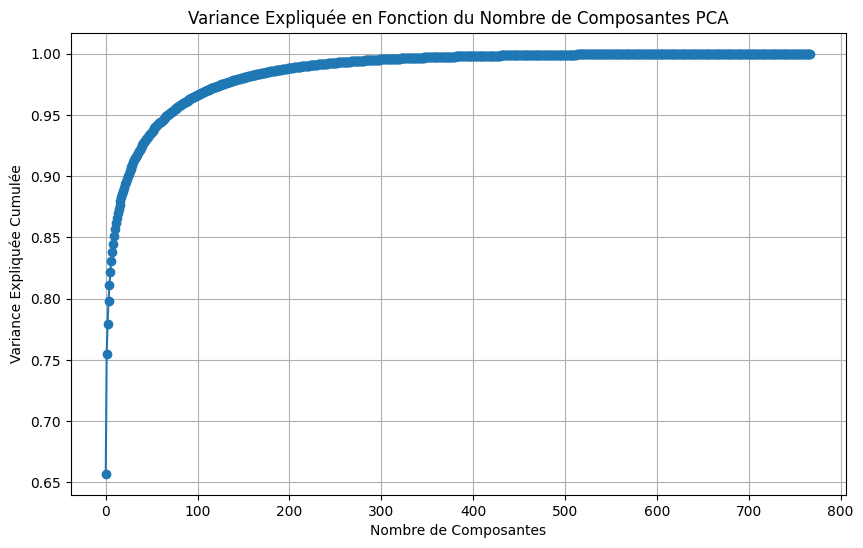

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convertir les vecteurs de caractéristiques en une matrice
features_matrix = np.array(df_sentiment['features'].tolist())

# Appliquer PCA sans réduire les dimensions
pca = PCA()
pca.fit(features_matrix)

# Calculer la variance expliquée cumulée
variance_cumulee = np.cumsum(pca.explained_variance_ratio_)

# Tracer la courbe de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(variance_cumulee, marker='o')
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulée')
plt.title('Variance Expliquée en Fonction du Nombre de Composantes PCA')
plt.grid()
plt.show()

on garde 100 composantes qui résument 95% de l'information

## PCA

In [24]:
# !pip install scikit-learn

from sklearn.decomposition import PCA
import numpy as np

# Combien de composantes vous souhaitez garder
n_components = 100  

# Convertir la liste de vecteurs en une matrice NumPy
features_matrix = np.array(df_sentiment['features'].tolist())

# Initialiser PCA
pca = PCA(n_components=n_components)

# Appliquer PCA
reduced_features = pca.fit_transform(features_matrix)

# Ajouter les caractéristiques réduites au DataFrame
df_sentiment['reduced_features'] = list(reduced_features)


# Clustering 

## Trouver le Nombre Optimal de Clusters

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

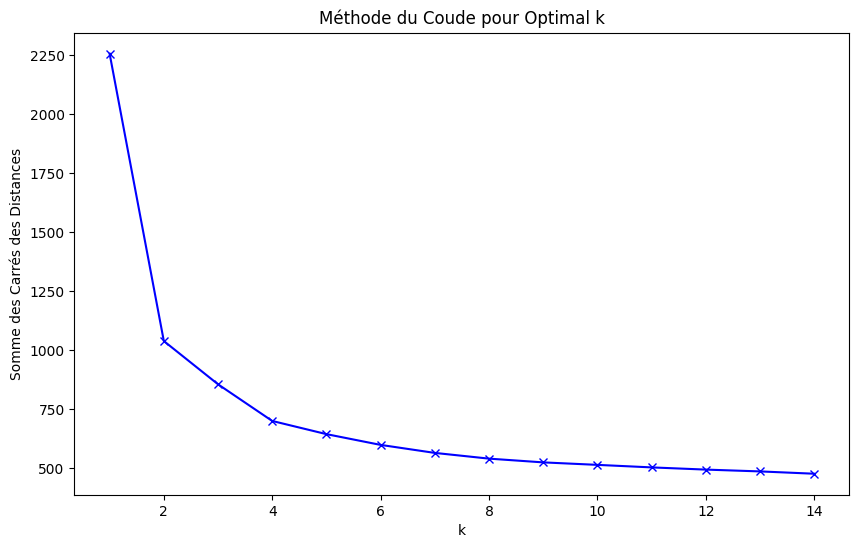

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Préparation des données pour le clustering
# Supposons que vous ayez déjà réduit les dimensions de vos vecteurs de caractéristiques
data_for_clustering = np.array(df_sentiment['reduced_features'].tolist())

# Tester K-means avec différents nombres de clusters
sum_of_squared_distances = []
K = range(1, 15)  # Par exemple, tester de 1 à 14 clusters
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_for_clustering)
    sum_of_squared_distances.append(km.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Somme des Carrés des Distances')
plt.title('Méthode du Coude pour Optimal k')
plt.show()

On va choisir 4 cluster 

## K-means avec le Nombre Optimal de Clusters

In [26]:
# Remplacer 'k_optimal' par le nombre de clusters choisi
k_optimal = 4 

# Création du modèle K-means
kmeans = KMeans(n_clusters=k_optimal)
kmeans = kmeans.fit(data_for_clustering)

# Ajout des étiquettes de cluster au DataFrame
df_sentiment['cluster_texte'] = kmeans.labels_


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Identifier les Mots-Clés les Plus Fréquents

In [27]:
from collections import Counter
import itertools

# Vous devez définir n_clusters sur le nombre de clusters que vous avez choisi précédemment.
n_clusters = k_optimal

# Fonction pour extraire les mots les plus fréquents
def get_top_keywords(data, n=10):
    words = data.str.split().tolist()
    words = list(itertools.chain(*words))
    # Supposons que vous avez une liste des stop words à exclure
    # words_filtered = [word for word in words if word not in stop_words]
    common_words = Counter(words).most_common(n)
    return common_words

# Afficher les mots les plus fréquents pour chaque cluster
for i in range(n_clusters):
    print(f"Cluster {i} : Mots-clés les plus fréquents\n")
    common_words = get_top_keywords(df_sentiment[df_sentiment['cluster_texte'] == i]['cleaned_text'])
    print(common_words)
    print("-" * 50)


Cluster 0 : Mots-clés les plus fréquents

[('de', 4063), ('la', 2188), ('l', 1550), ('le', 1505), ('et', 1408), ('des', 1376), ('à', 1234), ('les', 1188), ('du', 1077), ('d', 911)]
--------------------------------------------------
Cluster 1 : Mots-clés les plus fréquents

[('de', 36720), ('la', 19935), ('et', 15463), ('l', 14775), ('des', 13744), ('le', 12773), ('à', 11753), ('les', 11286), ('du', 9398), ('d', 8985)]
--------------------------------------------------
Cluster 2 : Mots-clés les plus fréquents

[('de', 1203), ('la', 649), ('des', 448), ('l', 429), ('le', 418), ('à', 415), ('et', 346), ('les', 339), ('du', 306), ('d', 249)]
--------------------------------------------------
Cluster 3 : Mots-clés les plus fréquents

[('de', 572), ('la', 355), ('et', 227), ('des', 193), ('les', 191), ('l', 189), ('le', 177), ('à', 171), ('a', 168), ('du', 160)]
--------------------------------------------------


In [28]:
# !pip install spacy
# !python -m spacy download fr_core_news_sm

import spacy
from spacy.lang.fr.stop_words import STOP_WORDS

# Charger le modèle de langue française de spaCy
nlp = spacy.load('fr_core_news_sm')

# Liste supplémentaire de mots à exclure
additional_exclusions = {"l", "d", "s", "n", "c", "qu"}

# Mettre à jour les stop words
stop_words = STOP_WORDS.union(additional_exclusions)

def get_top_keywords(data, n=10):
    words = data.str.split().tolist()
    words = list(itertools.chain(*words))
    words_filtered = [word for word in words if word not in stop_words and len(word) > 2]
    common_words = Counter(words_filtered).most_common(n)
    return common_words

# Afficher les mots les plus fréquents pour chaque cluster, à l'exclusion des stop words
for i in range(n_clusters):
    print(f"Cluster {i} : Mots-clés les plus fréquents sans stop words\n")
    common_words = get_top_keywords(df_sentiment[df_sentiment['cluster_texte'] == i]['cleaned_text'])
    print(common_words)
    print("-" * 50)

Cluster 0 : Mots-clés les plus fréquents sans stop words

[('pays', 234), ('été', 168), ('gouvernement', 147), ('ministre', 140), ('Sénégal', 125), ('Les', 119), ('président', 118), ('Afrique', 112), ('développement', 112), ('prix', 104)]
--------------------------------------------------
Cluster 1 : Mots-clés les plus fréquents sans stop words

[('pays', 1804), ('été', 1112), ('Les', 1094), ('Sénégal', 996), ('Afrique', 968), ('faire', 919), ('développement', 858), ('Etat', 784), ('Nous', 675), ('contre', 674)]
--------------------------------------------------
Cluster 2 : Mots-clés les plus fréquents sans stop words

[('pays', 54), ('Sénégal', 50), ('Les', 48), ('été', 46), ('gouvernement', 44), ('prix', 42), ('Afrique', 40), ('président', 36), ('ministre', 33), ('Etat', 32)]
--------------------------------------------------
Cluster 3 : Mots-clés les plus fréquents sans stop words

[('prix', 32), ('été', 26), ('Nous', 22), ('Les', 22), ('pays', 20), ('Afrique', 20), ('Sénégal', 19),

# Nombre d'articles par cluster

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


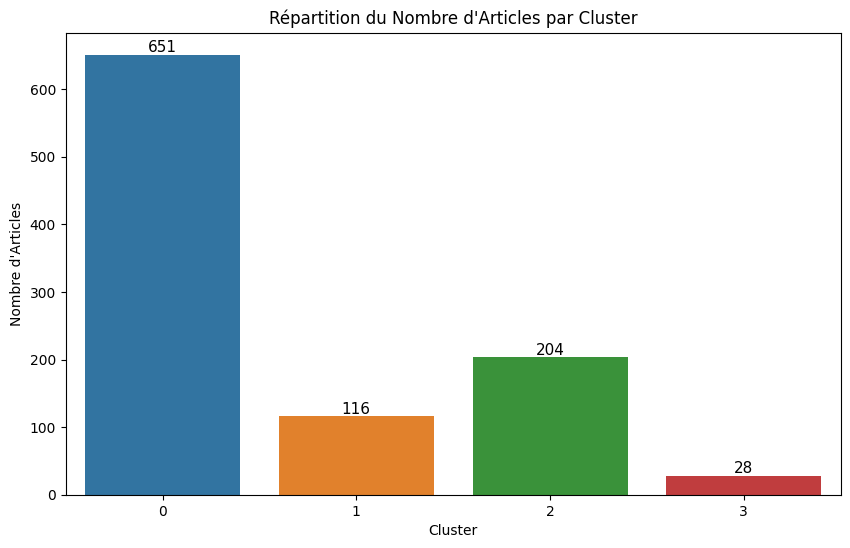

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Supposons que vous avez choisi un nombre optimal de clusters, par exemple 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k)
df_sentiment['cluster_texte'] = kmeans.fit_predict(data_for_clustering)

# Créer un histogramme pour visualiser la répartition du nombre d'articles par cluster
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cluster_texte', data=df_sentiment)
plt.title('Répartition du Nombre d\'Articles par Cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'Articles')

# Ajouter le nombre d'articles au-dessus de chaque barre
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=11, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()


# Article le plus proche du centroïde de chaque cluster

In [31]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Assurez-vous que kmeans est ajusté avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(data_for_clustering)

# Sauvegarder les centroïdes
centroids = kmeans.cluster_centers_

# Attribuer les étiquettes de cluster à votre DataFrame
df_sentiment['cluster_texte'] = kmeans.labels_

# Trouver l'article le plus représentatif pour chaque cluster
for cluster_num in range(k_optimal):
    # Récupérer les caractéristiques des articles de ce cluster
    cluster_features = data_for_clustering[df_sentiment['cluster_texte'] == cluster_num]
    
    # Calculer la distance euclidienne de chaque article du cluster à son centroïde
    distances = [distance.euclidean(article, centroids[cluster_num]) for article in cluster_features]
    
    # Trouver l'index de l'article le plus proche du centroïde
    closest_article_index = distances.index(min(distances))
    
    # Récupérer l'article le plus représentatif en utilisant l'index
    closest_article = df_sentiment.iloc[df_sentiment[df_sentiment['cluster_texte'] == cluster_num].index[closest_article_index]]
    
    print(f"Cluster {cluster_num}: Article le plus représentatif :\n{closest_article['cleaned_text']}\n")
    print("-" * 80)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: Article le plus représentatif :
Inondations dans la banlieue L Etat encore rassuré le risque persiste Le marigot de Mbao réceptacle des eaux de pluies venant de et environs est plein En attestent les inquiétudes des autorités lors d un Comité régional de développement Crd sur les inondations tenu le avril dernier à la Chambre de commerce d industrie et d agriculture de Dakar Cciad Tout porte à croire que la stagnation de l eau risque d avoir des conséquences sur les inondations dans la zone Interrogé hier jeudi avril sur la question le ministre chargé des Collectivités territoriales et porte parole du gouvernement a annoncé que des études seront faites afin de voir comment prendre en charge la question Ce qui atteste l absence de solutions d urgence Par ailleurs le ministre croit fortement que certains quartiers de fortement impactés par les inondations les années précédentes sont actuellement bien assainis et n éprouveront plus la furie des eaux La construction d ouvrages d

In [32]:
df_sentiment

,label,id,text,predicted_label,confidence,CLS_Relevance Yes/No,predicted_label_MLM,confidence_mlm,Polarity,Subjectivity,...,Sentiment_classe,Confidence,sentiment_bert,cluster_sentiment,cleaned_text,tokenized_text,tokens,features,reduced_features,cluster_texte
0,NaN,RJ5H4F3A8T,""" "" : quand les tensions entre le Maroc et l’...",0,0.606776,No (m),1,0.729357,0.057097,0.214516,...,0,0.305406,Négatif,2,quand les tensions entre le Maroc et l Algéri...,"[5, 206, 19, 8474, 128, 16, 3175, 14, 17, 6278...","([[tensor(5), tensor(206), tensor(19), tensor(...","[0.024499387, 0.07745864, -0.07062404, 0.10104...","[-0.85545474, -0.057424664, -0.22529157, 0.103...",1
1,NaN,MAOS6IZWSH,Bradage des terres de l’aéroport léopold sédar...,0,0.816456,Yes (m),1,0.812326,0.064000,0.143333,...,0,0.362451,Négatif,2,Bradage des terres de l aéroport léopold sédar...,"[5, 17822, 491, 20, 4079, 8, 17, 14248, 17, 14...","([[tensor(5), tensor(17822), tensor(491), tens...","[0.01632963, 0.1335858, -0.04986352, 0.1067966...","[0.014265472, -0.098691545, -0.08719847, -0.02...",1
2,NaN,OQ8FYHDR2Q,COP21 : la Tunisie et 6 autres nouveaux pays a...,0,0.757143,No (m),1,0.684343,0.095405,0.178378,...,2,0.284874,Neutre,1,COP la Tunisie et autres nouveaux pays africai...,"[5, 20253, 13, 5716, 14, 214, 704, 256, 10026,...","([[tensor(5), tensor(20253), tensor(13), tenso...","[0.0129798, 0.06033397, -0.04298684, 0.1352905...","[-0.7804912, -0.06444927, -0.04923231, 0.18847...",1
3,NaN,CHIOM99SJZ,Saint-Louis- élection présidentielle de 2024 :...,1,0.637125,Yes (m),1,0.915263,0.084231,0.188462,...,3,0.409618,Positif,1,Saint Louis élection présidentielle de les apé...,"[5, 377, 2027, 11773, 3430, 8, 19, 33, 10034, ...","([[tensor(5), tensor(377), tensor(2027), tenso...","[-0.004221032, 0.10764573, -0.010292986, 0.118...","[0.6955261, -0.03954005, -0.054236855, -0.2985...",2
4,NaN,NHHFVWZDHE,Location de terres agricoles en milieu rural a...,1,0.605540,No (m),1,0.898125,0.039561,0.170877,...,3,0.273582,Positif,1,Location de terres agricoles en milieu rural a...,"[5, 6516, 8, 4079, 6024, 22, 886, 9687, 36, 17...","([[tensor(5), tensor(6516), tensor(8), tensor(...","[-0.0008354336, 0.077885985, -0.020141033, 0.1...","[-0.77262807, -0.07349734, -0.25768766, -0.018...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,NaN,TUDIKWP2XH,"L’Afrique face à l’Ukraine : s’engager, oui, s...",0,0.764944,No (m),1,0.734130,0.031785,0.157206,...,1,0.249161,Négatif,2,L Afrique face à l Ukraine s engager oui s ali...,"[5, 71, 2971, 461, 15, 17, 20616, 52, 11523, 7...","([[tensor(5), tensor(71), tensor(2971), tensor...","[0.018572586, 0.083822355, -0.03619351, 0.1172...","[-0.6454599, -0.3250872, -0.17402808, 0.273188...",1
995,NaN,QER9ZQEBV5,Les députés en séance plénière pour l’examen d...,1,0.577608,Yes (m),1,0.908876,0.081538,0.188462,...,0,0.278799,Négatif,2,Les députés en séance plénière pour l examen d...,"[5, 74, 6664, 22, 2386, 23391, 24, 17, 5753, 8...","([[tensor(5), tensor(74), tensor(6664), tensor...","[0.052087605, 0.038307622, -0.025075702, 0.080...","[1.6190246, -0.090931706, 0.37741455, -0.13422...",2
996,NaN,25U6N7JIBP,Forum sur l’investissement à Ryad: l’appel de ...,0,0.517440,No (m),1,0.871158,0.110000,0.200000,...,3,0.450137,Positif,1,Forum sur l investissement à Ryad l appel de a...,"[5, 2930, 32, 17, 5431, 15, 15149, 1012, 17, 1...","([[tensor(5), tensor(2930), tensor(32), tensor...","[-0.052940197, 0.12062971, 0.015100655, -0.020...","[3.4574049, 0.4569685, -0.060067195, 0.1217106...",0
997,NaN,6HO4NJIYBE,Communiqué de presse du MFDC\n\nMouvement pour...,0,0.847978,No (m),1,0.706712,0.040395,0.238514,...,0,0.617065,Négatif,2,Communiqué de presse du MFDC Mouvement pour le...,"[5, 20623, 8, 1197, 25, 188, 449, 8885, 9589, ...","([[tensor(5), tensor(20623), tensor(8), tensor...","[0.032592293, 0.07357678, -0.06022857, 0.12836...","[-0.6194719, -0.1927502, -0.1997507, 0.0808963...",1


In [34]:
df_sentiment.to_csv('/kaggle/working/df_sentiment2.csv', index=False)

In [36]:
import os
os.listdir('/kaggle/working')

['.virtual_documents', 'df_sentiment2.csv', 'df_sentiment.csv']